## Imports

In [1]:
import requests
import os
from PIL import Image, ImageDraw
from IPython.display import display
import easyocr
import numpy as np

## Utils

In [2]:
def create_directory(directory):
    """
    Create a directory if it does not exist.

    Parameters:
        directory (str): The directory path to create.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")


## Fetch image

In [3]:
def download_specific_file(url, save_dir):
    """
    Download a file from a given URL and save it to a specified directory.

    Parameters:
        url (str): The URL of the file to download.
        save_dir (str): The directory to save the downloaded file.
    """
    # Ensure that the save directory exists
    create_directory(save_dir)
    
    # Send a GET request to the URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Extract the filename
        file_name = url.split('/')[-1]
        
        # Save the file to the specified directory
        with open(os.path.join(save_dir, file_name), 'wb') as file:
            file.write(response.content)
        
        print(f"File '{file_name}' downloaded successfully!")
    else:
        print(f"Failed to fetch file from '{url}'")

# Example usage
url = 'https://wavenet.csir.co.za/OnlineData/CapeTown/images/cpWavedata.png'  # URL of the file you want to download
save_directory = 'files'  # Directory to save the file
download_specific_file(url, save_directory)

Directory 'files' already exists.
File 'cpWavedata.png' downloaded successfully!


## Crop into Sub images

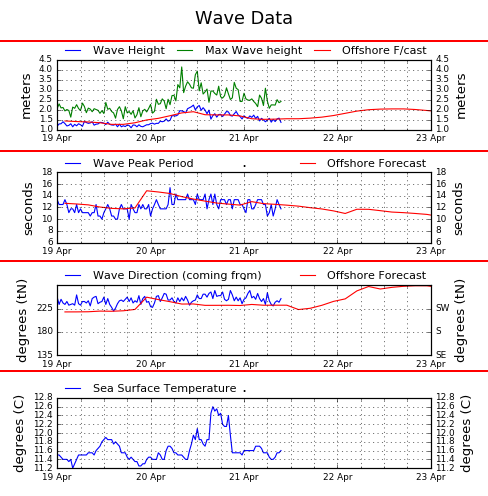

In [4]:

def overlay_horizontal_lines(image, line_positions, line_thickness=2):
    width, height = image.size
    draw = ImageDraw.Draw(image)
    
    for y in line_positions:
        draw.line((0, y, width, y), fill=(255, 0, 0), width=line_thickness)  # Green lines for horizontal grid
    
    display(image)  # Display the image with horizontal lines

# Example usage
image_path = "files/cpWavedata.png"
image = Image.open(image_path)
line_positions = [40, 150, 260, 370]  # Specify the positions of the horizontal lines
overlay_horizontal_lines(image, line_positions, line_thickness=2)  # Overlay with thicker horizontal lines at specified positions


In [5]:
def crop_and_save_images(image, line_positions, output_dir, prefix="graph_", skip_first=True):
    create_directory(output_dir)  # Create the output directory if it doesn't exist
    
    # Calculate cropping coordinates
    width, height = image.size
    num_crops = len(line_positions) - 1 if skip_first else len(line_positions)
    for i in range(num_crops):
        if skip_first:
            start_y = line_positions[i] + 1
        else:
            start_y = line_positions[i]
        end_y = line_positions[i + 1]
        
        # Crop the image
        crop = image.crop((0, start_y, width, end_y))
        
        # Save the cropped image
        filename = os.path.join(output_dir, f"{prefix}{i+1}.png")
        crop.save(filename)
        print(f"Image '{filename}' saved successfully.")

# Example usage
output_dir = "files/cropped_images"
image = Image.open(image_path)
crop_and_save_images(image, line_positions, output_dir, skip_first=True)

Directory 'files/cropped_images' already exists.
Image 'files/cropped_images/graph_1.png' saved successfully.
Image 'files/cropped_images/graph_2.png' saved successfully.
Image 'files/cropped_images/graph_3.png' saved successfully.


## OCR key features

I think I'm getting this wrong somehow. . . OCR not working as expected. 
Next thing to try is to crop the images. soooo

In [6]:
def perform_ocr(image_path, confidence_threshold=0.5, regions=None):
    # Initialize EasyOCR reader
    reader = easyocr.Reader(['en'], gpu=False , model_storage_directory='./models')
    
    
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # If regions are specified, draw rectangles representing each region
    if regions is not None:
        for region in regions:
            draw.rectangle(region, outline="green")
    
    # If regions are specified, crop the image to each region and perform OCR
    if regions is not None:
        for i, region in enumerate(regions):
            cropped_image = image.crop(region)
            
            # Convert PIL Image to numpy array
            cropped_array = np.array(cropped_image)
            
            # Perform OCR on the cropped array
            result = reader.readtext(cropped_array)
            
            # Print OCR results and draw bounding boxes
            print(f"OCR Result for region {i + 1} of {image_path}:")
            for detection in result:
                text, confidence, bbox = detection[1], detection[2], detection[0]
                print(f"Text: {text}, Confidence: {confidence}")
                
                # Filter out text based on confidence threshold
                if confidence >= confidence_threshold:
                    # Draw bounding box
                    bbox = [(x + region[0], y + region[1]) for x, y in bbox]  # Adjust bbox coordinates
                    draw.polygon(bbox, outline="red")
                    print(f"   Found '{text}' with confidence {confidence}")
    
    # Display the image with shapes and bounding boxes
    image.show()

In [8]:
image_path = 'files/cropped_images/graph_1.png'
regions = [(37, 10, 54, 22,), (37, 82, 55, 92),]  # Define multiple regions as (left, top, right, bottom)
perform_ocr(image_path, confidence_threshold=0.1, regions=regions)


Using CPU. Note: This module is much faster with a GPU.
